# "Project2-4"
> "ML을 이용한 대출 채무이행 판별"

- toc:true
- branch: master
- badges: true
- comments: true
- author: channee
- categories: [jupyter, ML, MachineLearning]

#### 가공된 최종 데이터 세트 생성
##### 지금까지 과정을 함수화
##### 이전에 application 데이터 세트의 feature engineering 수행 후 새롭게 previous 데이터 세트로 가공된 데이터를 조인. 

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [ ]:
def get_dataset():
    app_train = pd.read_csv('application_train.csv')
    app_test = pd.read_csv('application_test.csv')
    apps = pd.concat([app_train, app_test])
    prev = pd.read_csv('previous_application.csv')

    return apps, prev

apps, prev = get_dataset()
    

#### 이전 application 데이터의 feature engineering 함수 복사

In [ ]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

#### previous 데이터 가공후 인코딩 및 최종 데이터 집합 생성하는 함수 선언

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev
    
    
def get_prev_amt_agg(prev):
    # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
    agg_dict = {
         # 기존 컬럼. 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 가공 컬럼
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    return prev_refused_appr_agg

    

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.01,
                num_leaves=32,
                colsample_bytree=0.8,
                subsample=0.8,
                max_depth=8,
                reg_alpha=0.04,
                reg_lambda=0.07,
                min_child_weight=40,
                silent=-1,
                verbose=-1,
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

##### 최종 집합 생성 및 인코딩, 학습/테스트 데이터 분리, 학습/검증 피처와 타겟 데이터 분리

In [ ]:
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)


<ipython-input-4-cfb8ca96aa23>:53: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]


prev_agg shape: (338857, 41)
apps_all before merge shape: (356255, 135)
apps_all after merge with prev_agg shape: (356255, 176)


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

* 필요한 부분을 최대한 처리하여 Pipeline은 필요 없을 듯 하다.
* randomforest와 LightGBM, XGboost를 수행해보고자 한다

In [ ]:
# bayesian optimization 패키지 설치
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [ ]:
# parameter 별로 search할 범위를 설정. 
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [ ]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    proba = lgb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(valid_y, valid_proba)
    
    return roc_auc   

In [ ]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval,bayesian_params , random_state=0)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.769662	training's binary_logloss: 0.246032	valid_1's auc: 0.755483	valid_1's binary_logloss: 0.248917
[200]	training's auc: 0.787253	training's binary_logloss: 0.238487	valid_1's auc: 0.766224	valid_1's binary_logloss: 0.244243
[300]	training's auc: 0.798898	training's binary_logloss: 0.23398	valid_1's auc: 0.771467	valid_1's binary_logloss: 0.242344
[400]	training's auc: 0.807869	training's binary_logloss: 0.23065	valid_1's auc: 0.773972	valid_1's binary_logloss: 0.241458
[500]	training's auc: 0.815952	training's binary_logloss: 0.227669	valid_1's auc: 0.775806	valid_1's binary_logloss: 0.240831
Did not meet early stopping. Best iteratio

In [ ]:
# BayesianOptimization객체의 res는 iteration 수행 시마다 모든 함수 반환결과와 그때의 파라미터 결과값을 가지고 있음. 
lgbBO.res

[{'target': 0.7758055093230539,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.027633760716439,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 0.7757909289675659,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 11.288949197529044,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 0.7771779879367707,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.78618342232764,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.61248

##### Iteration 결과 Dictionary에서 최대 target값을 가지는 index 추출하고 그때의 parameter 값을 추출.  

In [ ]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

[0.7758055093230539, 0.7757909289675659, 0.7771779879367707, 0.7748333416046418, 0.774035094542375, 0.7773908017189786, 0.7755362516633085, 0.7772142029411041, 0.7763952615906466, 0.7734141467631326, 0.7756008426857747, 0.7771050305636831, 0.7772365047377109, 0.7773549981224318, 0.7767492867273098, 0.775929160395352, 0.7767777231064307, 0.7743690019971274, 0.7769920411479967, 0.7754041675256128, 0.7780565770624691, 0.7775081101221989, 0.7771685255576835, 0.7769187946775454, 0.7772230140569003, 0.777808998528086, 0.7771167374184544, 0.7764292464153193, 0.7763562620386317, 0.777091004576216]
maximum target index: 20


In [ ]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': 0.7780565770624691, 'params': {'colsample_bytree': 0.596684514717646, 'max_bin': 403.18943474881877, 'max_depth': 12.907058961217114, 'min_child_samples': 158.84286216603994, 'min_child_weight': 7.338287048901049, 'num_leaves': 58.11656509027165, 'reg_alpha': 0.6681705096965275, 'reg_lambda': 9.355145759543333, 'subsample': 0.8010238277727275}}


# 최적화된 하이퍼 파라미터를 기반으로 재 테스트 

In [ ]:
ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
lgbm_wrapper = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth = 13,
    num_leaves=58,
    colsample_bytree=0.597,
    subsample=0.801,
    max_bin=403,
    reg_alpha=0.668,
    reg_lambda=9.355,
    min_child_weight=7,
    min_child_samples=159,
    silent=-1,
    verbose=-1,
    )



evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=100)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

train shape: (215257, 174) valid shape: (92254, 174)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.759823	valid_0's binary_logloss: 0.24777
[200]	valid_0's auc: 0.769883	valid_0's binary_logloss: 0.242862
[300]	valid_0's auc: 0.773949	valid_0's binary_logloss: 0.241297
[400]	valid_0's auc: 0.776637	valid_0's binary_logloss: 0.240371
[500]	valid_0's auc: 0.77781	valid_0's binary_logloss: 0.239972
[600]	valid_0's auc: 0.778251	valid_0's binary_logloss: 0.239807
[700]	valid_0's auc: 0.778768	valid_0's binary_logloss: 0.239639
[800]	valid_0's auc: 0.778859	valid_0's binary_logloss: 0.239603
[900]	valid_0's auc: 0.779087	valid_0's binary_logloss: 0.239534
[1000]	valid_0's auc: 0.77916	valid_0's binary_logloss: 0.239504
Did not meet early stopping. Best iteration is:
[987]	valid_0's auc: 0.779182	valid_0's binary_logloss: 0.239501


In [ ]:
# 평가지표
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[84653   180]
 [ 7201   220]]
정확도: 0.9200, 정밀도: 0.5500, 재현율: 0.0296,          F1: 0.0563, AUC:0.7792


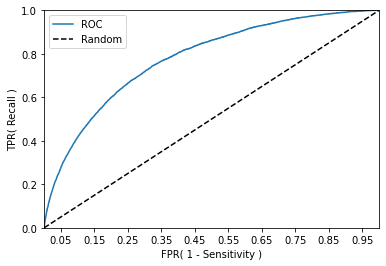

In [ ]:
# ROC curve
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, pred_proba)

##### cross validation 으로 hyper parameter 재 tuning

In [ ]:
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_data_in_leaf': (10, 200), # min_child_samples
    'min_child_weight':(1, 50),
    'bagging_fraction':(0.5, 1.0), # subsample
    'feature_fraction': (0.5, 1.0), # colsample_bytree
    'max_bin':(10, 500),
    'lambda_l2':(0.001, 10), # reg_lambda
    'lambda_l1': (0.01, 50) # reg_alpha
}

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(data=ftr_app, label=target_app, free_raw_data=False)
def lgb_roc_eval_cv(max_depth, num_leaves, min_data_in_leaf, min_child_weight, bagging_fraction, 
                 feature_fraction,  max_bin, lambda_l2, lambda_l1):   
    params = {
        "num_iterations":500, "learning_rate":0.02,
        'early_stopping_rounds':100, 'metric':'auc',
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 실수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_data_in_leaf': int(round(min_data_in_leaf)),
        'min_child_weight': int(round(min_child_weight)),
        'bagging_fraction': max(min(bagging_fraction, 1), 0), 
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'lambda_l2': max(lambda_l2,0),
        'lambda_l1': max(lambda_l1, 0)
    }
    # 파이썬 lightgbm의 cv 메소드를 사용. 
    
    cv_result = lgb.cv(params, train_data, nfold=3, seed=0,  verbose_eval =100,  early_stopping_rounds=50, metrics=['auc'])
    return max(cv_result['auc-mean'])   

In [ ]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval_cv,bayesian_params , random_state=0)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 |  max_bin  | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20217
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20217
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20217
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 164
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39937
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39937
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39937
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 170
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21674
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21674
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21674
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 166
[LightGBM] [Info] Start training from score 0.08072

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34163
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34163
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34163
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 170
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17490
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17490
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17490
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 170
[LightGBM] [Info] Start training from score 0.08072

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20299
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20299
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20299
[LightGBM] [Info] Number of data points in the train set: 205008, number of used f

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37203
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37203
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37203
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 169
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17390
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17390
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17390
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 164
[LightGBM] [Info] Start training from score 0.08072

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12896
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12896
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12896
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19499
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19499
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19499
[LightGBM] [Info] Number of data points in the train set: 205008, number of used f

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19007
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19007
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19007
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16402
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 165
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16402
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 165
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16402
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 165
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19579
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19579
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19579
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 164
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16894
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16816
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 165
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16816
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 165
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16816
[LightGBM] [Info] Number of data points in the train set: 205008, number of used f

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34319
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34319
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34319
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 170
[LightGBM] [Info] Start training from score 0.08072

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36283
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36283
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36283
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 167
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17800
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17800
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17800
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27374
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27374
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27374
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 166
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16818
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16818
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16818
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41759
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41759
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41759
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 164
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5318
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5318
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5318
[LightGBM] [Info] Num

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33376
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33376
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33376
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 166
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17478
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17478
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17478
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 164
[LightGBM] [Info] Start training from score 0.08072

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14077
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14077
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14077
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 167
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11051
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11051
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11051
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 167
[LightGBM] [Info] Start training from score 0.080729
[LightGBM] [Info] Start training from score 0.080729
[LightGBM

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18842
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18842
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 164
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18842
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14825
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14825
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14825
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15329
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15329
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15329
[LightGBM] [Info] 

C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\channee\anaconda3\lib\site-packages\lightgbm\engine.py:532: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15248
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15248
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 167
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15248
[LightGBM] [Info] 

In [ ]:
lgbBO.res

[{'target': 0.7704130128940919,
  'params': {'bagging_fraction': 0.7744067519636624,
   'feature_fraction': 0.8575946831862098,
   'lambda_l1': 30.142141169821482,
   'lambda_l2': 5.449286946785972,
   'max_bin': 217.5908516760633,
   'max_depth': 12.458941130666561,
   'min_child_weight': 22.441773351871934,
   'min_data_in_leaf': 179.43687014859515,
   'num_leaves': 62.54651042004117}},
 {'target': 0.7707320615580647,
  'params': {'bagging_fraction': 0.6917207594128889,
   'feature_fraction': 0.8958625190413323,
   'lambda_l1': 26.449457038447697,
   'lambda_l2': 5.680877566378229,
   'max_bin': 463.5423527634039,
   'max_depth': 6.710360581978869,
   'min_child_weight': 5.269335685375495,
   'min_data_in_leaf': 13.841495513661886,
   'num_leaves': 57.30479382191752}},
 {'target': 0.7674060125927115,
  'params': {'bagging_fraction': 0.8890783754749252,
   'feature_fraction': 0.9350060741234096,
   'lambda_l1': 48.93113092821587,
   'lambda_l2': 7.99178648360302,
   'max_bin': 236.124

In [ ]:
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

[0.7704130128940919, 0.7707320615580647, 0.7674060125927115, 0.7706174479634317, 0.7692640265604144, 0.7707441174483378, 0.770229710649176, 0.7719096310120473, 0.7691251381694691, 0.7705267701934897, 0.7710389366063817, 0.7718773672753726, 0.7711454074315656, 0.7695691149218623, 0.7724457191365559, 0.7702728801817355, 0.7691546772195966, 0.7718560657970831, 0.7708603583870698, 0.7719703571205899, 0.77054013792762, 0.7684607098023677, 0.7687114634910718, 0.7718111662970083, 0.7716905284261153, 0.7701900669922322, 0.7708307863985207, 0.7719997542250262, 0.7722128809560068, 0.7709315329107215]
maximum target index: 14


In [ ]:
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': 0.7724457191365559, 'params': {'bagging_fraction': 0.9299169469599182, 'feature_fraction': 0.5746809011453164, 'lambda_l1': 7.543441207233135, 'lambda_l2': 3.292195078359306, 'max_bin': 177.94521484058205, 'max_depth': 10.61966768561966, 'min_child_weight': 1.397663097770165, 'min_data_in_leaf': 166.95618212603793, 'num_leaves': 54.18985368611588}}


In [ ]:
ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
lgbm_wrapper = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    max_depth = 11,
    num_leaves=54,
    colsample_bytree=0.574,
    subsample=0.930,
    max_bin=403,
    reg_alpha=7.543,
    reg_lambda=3.292,
    min_child_weight=1,
    min_child_samples=167,
    silent=-1,
    verbose=-1,
    )



evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=100)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

train shape: (215257, 174) valid shape: (92254, 174)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.759222	valid_0's binary_logloss: 0.248113
[200]	valid_0's auc: 0.769117	valid_0's binary_logloss: 0.24319
[300]	valid_0's auc: 0.773816	valid_0's binary_logloss: 0.241396
[400]	valid_0's auc: 0.77635	valid_0's binary_logloss: 0.24053
[500]	valid_0's auc: 0.777994	valid_0's binary_logloss: 0.239917
[600]	valid_0's auc: 0.77869	valid_0's binary_logloss: 0.239651
[700]	valid_0's auc: 0.779292	valid_0's binary_logloss: 0.239452
[800]	valid_0's auc: 0.779592	valid_0's binary_logloss: 0.239369
[900]	valid_0's auc: 0.77968	valid_0's binary_logloss: 0.239334
[1000]	valid_0's auc: 0.779873	valid_0's binary_logloss: 0.239287
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.779896	valid_0's binary_logloss: 0.239281


In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[84646   187]
 [ 7200   221]]
정확도: 0.9199, 정밀도: 0.5417, 재현율: 0.0298,          F1: 0.0565, AUC:0.7799


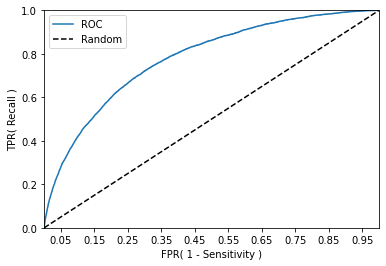

In [ ]:
roc_curve_plot(y_test, pred_proba)